# Progetto di calcolo numerico: deblur Immagini 
Il problema di deblur consiste nella ricostruzione di un immagine a partire da un dato acquisito mediante il seguente modello:

\begin{align*}
    b = A x + \eta
\end{align*}

dove $b$ rappresenta l'immagine corrotta, $x$ l'immagine originale che vogliamo ricostruire, $A$ l'operatore che applica il blur Gaussiano ed $\eta$ il rumore additivo con distribuzione Gaussiana di  media $\mathbb{0}$ e deviazione standard $\sigma$.

# Libreria funzioni:


*   Impostazione di costanti e parametri
*   Funzioni necessarie per applicare blur Gaussiano
*   Implementazione metodo del gradiente


In [7]:
#{ PARAMETRI }#
dim_kernel = 9 #dim effettiva dim_kernel*dim_kernel
sigma = 1.3 #sigma per generazione kernel gaussiano 
deviazione = 0.025 #deviazione standard per filtro di noise

l =  10.e-3 #parametro lambda per regolarizzazione di f(x)
max_iterations = 6 #limite iterazioni per funzione minimize


import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics, io
from scipy import signal
from scipy.optimize import minimize
from numpy import fft

#{ FUNZIONI }#
def gaussian_kernel(kernlen, sigma): 
    x = np.linspace(- (kernlen // 2), kernlen // 2, kernlen)    
    # Unidimensional Gaussian kernel
    kern1d = np.exp(- 0.5 * (x**2 / sigma))
    # Bidimensional Gaussian kernel
    kern2d = np.outer(kern1d, kern1d)
    # Normalization
    return kern2d / kern2d.sum()

def psf_fft(k, d, shape): # Compute the FFT of the kernel 'K' of size 'd' padding with the zeros necessary to match the size of 'shape'
    # Zero padding
    K_p = np.zeros(shape)
    K_p[:d, :d] = k
    # Shift
    p = d // 2
    K_pr = np.roll(np.roll(K_p, -p, 0), -p, 1)
    # Compute FFT
    K_otf = fft.fft2(K_pr)
    return K_otf

# Multiplication by A
def A(x, K): #x = matrice, K= filtro di convoluzione
  x = fft.fft2(x)
  return np.real(fft.ifft2(K * x)) 

# Multiplication by A transpose
def AT(x, K): 
  x = fft.fft2(x)
  return np.real(fft.ifft2(np.conj(K) * x)) 

# Minimize custom implementation
def next_step(x,grad): # backtracking procedure for the choice of the steplength
  alpha=1.1
  rho = 0.5
  c1 = 0.25
  p=-grad
  j=0
  jmax=10
  while ((f(x+alpha*p) > f(x)+c1*alpha*grad.T@p) and j<jmax ):
    alpha= rho*alpha
    j+=1
  if (j>jmax):
    return -1
  else:
    return alpha

def my_minimize(x0,b,MAXITERATION,ABSOLUTE_STOP): # funzione che implementa il metodo del gradiente
  #declare x_k and gradient_k vectors

  x=np.zeros((img_m*img_n,MAXITERATION))
  norm_grad_list=np.zeros((img_m*img_n,MAXITERATION))
  function_eval_list=np.zeros((img_m*img_n,MAXITERATION))
  error_list=np.zeros((img_m*img_n,MAXITERATION))
  
  #initialize first values
  x_last = x0
  x[:,0] = x_last
  k=0

  function_eval_list[:,k]=f(x_last)
  error_list[:,k]=np.linalg.norm(x_last-b)
  norm_grad_list[:,k]=np.linalg.norm(grad_f(x_last))

  while (np.linalg.norm(grad_f(x_last))>ABSOLUTE_STOP and k < MAXITERATION -1 ):

    k=k+1
    grad = grad_f(x_last)#direction is given by gradient of the last iteration

    # backtracking step
    step = next_step(x_last,grad)
    
    if(step==-1):
      print('non convergente')
      return k #no convergence

    x_last=x_last-step*grad
    x[:,k] = x_last

    function_eval_list[:,k]=f(x_last)
    error_list[:,k]=np.linalg.norm(x_last-b)
    norm_grad_list[:,k]=np.linalg.norm(grad_f(x_last))

  function_eval_list = function_eval_list[:,:k+1]
  error_list = error_list[:,:k+1]
  norm_grad_list = norm_grad_list[:,:k+1]

  return (x_last,norm_grad_list, function_eval_list, error_list, k)

# Caricamento immagine e applicazione filtri

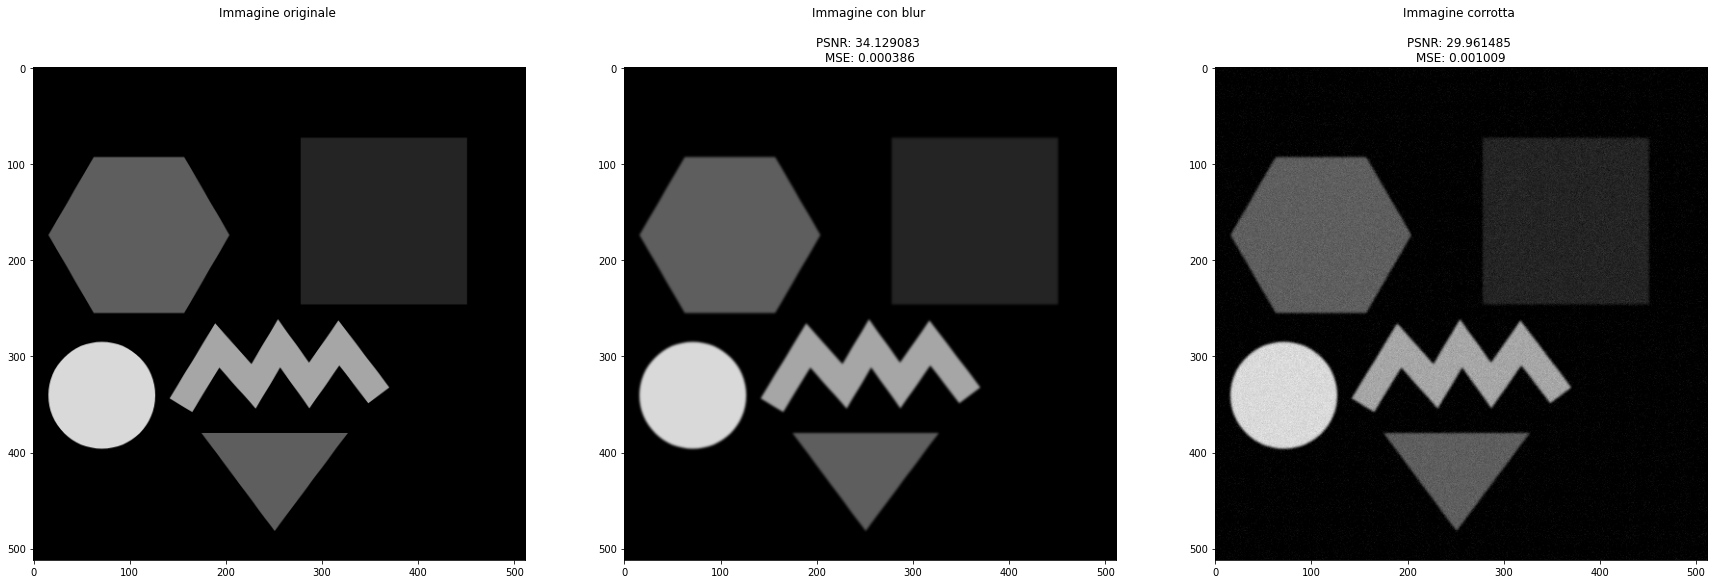

In [2]:
#{ CARICAMENTO }#
image_name = '1' #immagine 1 fornita nella cartella images / caricare immagine a piacere nella root di upload e modificare il nome
Y = plt.imread('/content/{img}.png'.format(img=image_name)).astype(np.float64)
X = Y[:,:,0] 
img_m, img_n = X.shape

#{ FILTRI }#
K = psf_fft(gaussian_kernel(dim_kernel, sigma), dim_kernel, X.shape) #Genera il filtro di blur

noise = np.random.normal(size= X.shape)*deviazione #Vettore di numeri casuali con media 0 e  deviazione standard sigma

b_blur = A(X,K) #Aggiungi il filtro blur e rumore generato da K
b = b_blur + noise 

PSNRb= metrics.peak_signal_noise_ratio(X,b_blur)  #PSNR = metrics.peak_signal_noise_ratio(X, X_ricostruita)
MSEb = metrics.mean_squared_error(X, b_blur) #errore relativo tra le due immagini
PSNRc= metrics.peak_signal_noise_ratio(X,b)
MSEc = metrics.mean_squared_error(X, b) 

#-> PLOT <-#
plt.figure(figsize=(30,10))
ax1 = plt.subplot(1, 3, 1)
ax1.imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title('Immagine originale \n \n \n')
ax2 = plt.subplot(1 ,3, 2)
ax2.imshow(b_blur, cmap='gray', vmin=0, vmax=1)
plt.title('Immagine con blur \n \n'+ 'PSNR: {0:.6f}'.format(PSNRb) + ' \n'+ 'MSE: {0:.6f}'.format(MSEb))
ax2 = plt.subplot(1 ,3, 3)
ax2.imshow(b, cmap='gray', vmin=0, vmax=1)
plt.title('Immagine corrotta \n \n'+ 'PSNR: {0:.6f}'.format(PSNRc) + ' \n'+ 'MSE: {0:.6f}'.format(MSEc))
plt.show()

#Soluzione naive

Ricostruzione dell'immagine originale $x$ partendo dall'immagine corrotta $b$ risolvendo il seguente problema di ottimizzazione utilizzando il metodo del gradiente coniugato implementato in *scipy.optimize.minimize*:
\begin{align}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2
\end{align}

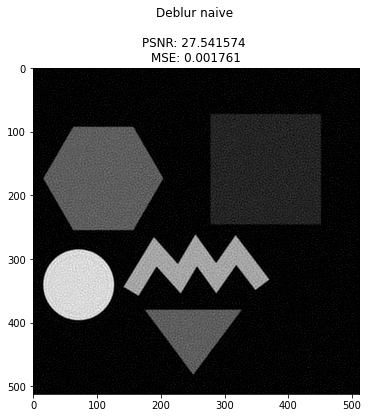

In [3]:
def f(x): #definizione di f(x)
  X = x.reshape(img_m, img_n)
  res = np.subtract(A(X, K),b)
  return 0.5 * np.linalg.norm(res)**2

def df(x): #definizione di gradiente di f(x)
  X= x.reshape(img_m, img_n)
  res = AT(np.subtract(A(X, K), b), K)
  return res.flatten()

x0 = np.zeros(img_m*img_n) #matrice unidimensionale iniziale
result = minimize(f, x0, method='CG', jac=df, options= {'maxiter' : max_iterations}) #minimizzazione utilizzando il metodo dei gradienti coniugati

#{ STATS & PLOT }#
minimized_image1 = result.x.reshape(img_m, img_n)
plt.figure(figsize=(6,6))
PSNRn= metrics.peak_signal_noise_ratio(X, minimized_image1)
MSEn = metrics.mean_squared_error(X, minimized_image1)
plt.imshow(minimized_image1, cmap='gray', vmin=0, vmax=1)
plt.title('Deblur naive \n \n'+ 'PSNR: {0:.6f}'.format(PSNRn) + ' \n'+ 'MSE: {0:.6f}'.format(MSEn))
plt.show()

# Regolarizzazione
Per ridurre gli effetti del rumore nella ricostruzione introduciamo il termine di regolarizzazione di Tikhonov. Il problema di minimizzazione diviene quindi:
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2
\end{align*}



> Minimizzazione utilizzando medoto del gradiente coniugato di *scipy.optimize.minimize*:


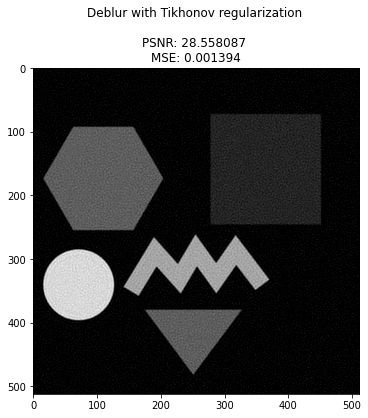

In [8]:
def fr(x): #definizione di f(x) con regolarizzazione di Tikhonov con parametro lambda = l
  X= x.reshape(img_m, img_n)
  res = 0.5 * np.linalg.norm(np.subtract(A(X, K), b))**2
  tikhonov = l*0.5 * np.linalg.norm(X)**2
  return res + tikhonov

def dfr(x): #definizione del gradiente di f(x) regolarizzata
  X= x.reshape(img_m, img_n)
  res = AT(np.subtract(A(X, K), b), K) + l*X
  return res.flatten()

x0 = np.zeros(img_m*img_n)
result = minimize(fr, x0, method='CG', jac=dfr, options= {'maxiter' : max_iterations})

#{ STATS & PLOT }#
minimized_image2 = result.x.reshape(img_m, img_n)
plt.figure(figsize=(6,6))
PSNRtc= metrics.peak_signal_noise_ratio(X, minimized_image2)
MSEtc = metrics.mean_squared_error(X, minimized_image2)
plt.imshow(minimized_image2, cmap='gray', vmin=0, vmax=1)
plt.title('Deblur with Tikhonov regularization \n \n'+ 'PSNR: {0:.6f}'.format(PSNRtc) + ' \n'+ 'MSE: {0:.6f}'.format(MSEtc))
plt.show()



> Minimizzazione utilizzando il medoto del gradiente custom di *my_minimize*:



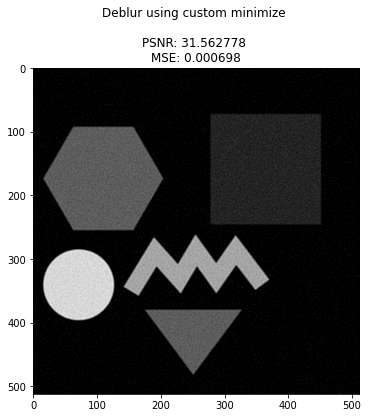

In [9]:
def f(x): #definizione di f(x) per minimizzazione utilizzando l'implementazione del metodo del gradiente
  X= x.reshape(img_m, img_n)
  b= b_m.reshape(img_m, img_n)
  res = 0.5 * np.linalg.norm(np.subtract(A(X, K), b))**2
  tikhonov = l*0.5 * np.linalg.norm(X)**2
  return res + tikhonov

def grad_f(x): #definizione del gradiente di f(x) per minimizzazione utilizzando l'implementazione del metodo del gradiente
  X= x.reshape(img_m, img_n)
  b= b_m.reshape(img_m, img_n)
  res = AT(np.subtract(A(X, K), b), K) + l*X
  return np.reshape(res, img_m*img_n)

MAXITERATIONS=10
ABSOLUTE_STOP=1.e-5
x0 = np.ones(img_m*img_n)
b_m = b.flatten() #immagine corrotta in forma unidimensionale
(x_last,norm_grad_list, function_eval_list, error_list, k)= my_minimize(x0, b_m,MAXITERATIONS, ABSOLUTE_STOP) #minimizzazione con metodo del gradiente

#{ STATS & PLOT }#
minimized_image_my_minimize= x_last.reshape(img_m, img_n)
plt.figure(figsize=(6,6))
PSNRtg= metrics.peak_signal_noise_ratio(X, minimized_image_my_minimize)
MSEtg = metrics.mean_squared_error(X, minimized_image_my_minimize)
plt.imshow(minimized_image_my_minimize, cmap='gray', vmin=0, vmax=1)
plt.title('Deblur using custom minimize \n \n'+ 'PSNR: {0:.6f}'.format(PSNRtg) + ' \n'+ 'MSE: {0:.6f}'.format(MSEtg))
plt.show()



# Comparazione risultati

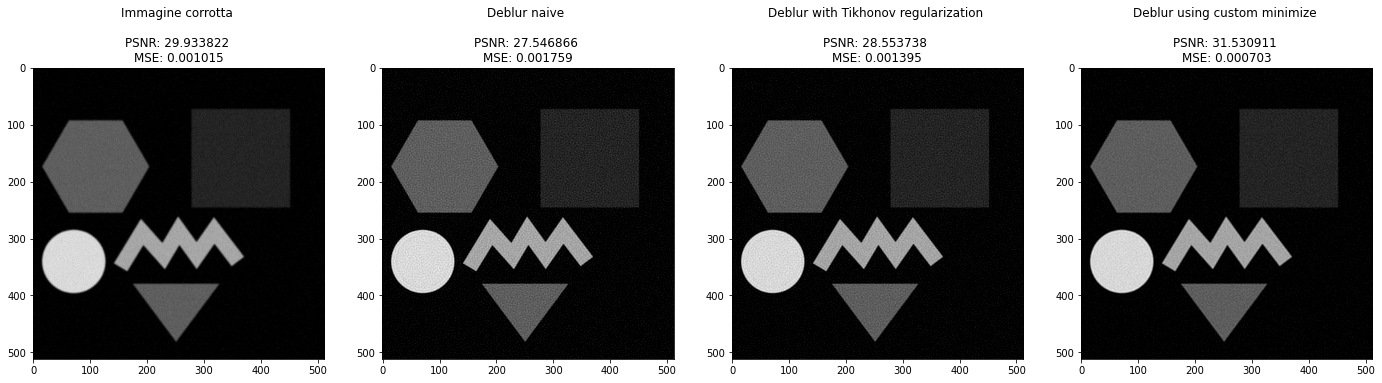

In [ ]:
plt.figure(figsize=(24,6))
ax1 = plt.subplot(1 ,4, 1)
ax1.imshow(b, cmap='gray', vmin=0, vmax=1)
plt.title('Immagine corrotta \n \n'+ 'PSNR: {0:.6f}'.format(PSNRc) + ' \n'+ 'MSE: {0:.6f}'.format(MSEc))
ax2 = plt.subplot(1 ,4, 2)
ax2.imshow(minimized_image1, cmap='gray', vmin=0, vmax=1)
plt.title('Deblur naive \n \n'+ 'PSNR: {0:.6f}'.format(PSNRn) + ' \n'+ 'MSE: {0:.6f}'.format(MSEn))
ax2 = plt.subplot(1 ,4, 3)
ax2.imshow(minimized_image2, cmap='gray', vmin=0, vmax=1)
plt.title('Deblur with Tikhonov regularization \n \n'+ 'PSNR: {0:.6f}'.format(PSNRtc) + ' \n'+ 'MSE: {0:.6f}'.format(MSEtc))
ax3 = plt.subplot(1 ,4, 4)
ax3.imshow(minimized_image_my_minimize, cmap='gray', vmin=0, vmax=1)
plt.title('Deblur using custom minimize \n \n'+ 'PSNR: {0:.6f}'.format(PSNRtg) + ' \n'+ 'MSE: {0:.6f}'.format(MSEtg))
plt.show()
